In [1]:

import os
import re

import argparse

import numpy as np
import pandas as pd

import collections as cl

from tqdm import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 11,
                     'axes.titlesize': 15,     # title font size
                     'axes.labelsize': 13,     # xlabel/ylabel font size
                     'axes.linewidth': 1.5,    # axis width
                     'xtick.labelsize': 11,    # xticks font size
                     'ytick.labelsize': 11,    # yticks font size
                     'xtick.major.size': 6,    # xticks length
                     'xtick.major.width': 1.5, # xticks width
                     'ytick.major.size': 6,    # yticks length
                     'ytick.major.width': 1.5, # yticks width
                     })


import pysam



In [13]:
def extract_bam(bam_path):
    
        
    def get_CGcont(line):
        count_dict = cl.Counter(line)
        return count_dict

    def cal_CGcont(count_dict):
        return (count_dict['C'] + count_dict['G'])/(count_dict['A'] + count_dict['T']
                                                    + count_dict['C'] + count_dict['G'])
    
    
    
    bam_list = []
    bamfile = pysam.AlignmentFile(bam_path, "rb")
    for line in bamfile.fetch():
        if not line.query:  ## second alignment is omitted
            continue
        bam_list.append([line.query_name, line.query_length, line.reference_name,
                         line.reference_start, line.reference_end, line.query_alignment_length,
                         line.flag, line.get_tag('AS'), line.mapping_quality,
                         cal_CGcont(get_CGcont(line.query))])
    bamfile.close()

    ## data frame
    bam_dataframe = pd.DataFrame(bam_list)
    bam_dataframe.columns = ['read_name', 'read_length', 'reference_name', 'ref_start',
                             'ref_end', 'query_alignment_length', 'FALG', 'DP_score', 'MAPQ',
                             'CGcont']

    return bam_dataframe

In [14]:
def each_region_check(region_name, region_interest, bam_info):
    region_search  = re.search('([^:]*):([0-9]*)-([0-9]*)', region_interest)
    chrom_interest = region_search.group(1)
    start_interest = int(region_search.group(2))
    end_interest = int(region_search.group(3))

    region_info = bam_info.loc[(bam_info['reference_name'] == chrom_interest)
                               & (bam_info['ref_start'] <= start_interest)
                               & (bam_info['ref_end'] >= end_interest)].copy(deep=True)

    region_info['region_index'] = region_name

    return region_info

In [15]:
def bed_file_reader(bed_path):
    region_name = []
    region_interest = []
    with open(bed_path, 'r') as file:
        for i, line in enumerate(file):
            line_list = line.strip().split()
            if len(line_list) < 4:
                region_name.append('loc_%s' % i)
            else:
                region_name.append('loc_%s/%s' % (i, line_list[3]))
            region_interest.append('%s:%s-%s' % (line_list[0],line_list[1],line_list[2]))
    return region_name, region_interest

In [16]:
region_name, region_interest = bed_file_reader('../../Project_deepForensicSTR/comparison/alignment/alignment_plots/locus.bed')

bam_info = extract_bam('../../Project_deepForensicSTR/comparison/alignment/barcode03.bam')

In [17]:
info_dfs = []
for i, each_region in enumerate(region_interest):
    info_dfs.append(each_region_check(region_name[i], each_region, bam_info))

info_dfs = pd.concat(info_dfs)

In [18]:
region_dist = pd.DataFrame(info_dfs['region_index'].value_counts())
region_dist.reset_index(inplace=True)
region_dist.columns = ['regions', 'counts']
region_dist['sort_ind'] = region_dist['regions'].str.extract('(\d+)', expand=False).astype(int)
region_dist.sort_values(by=['sort_ind'], inplace=True, ascending=True)
region_dist.drop('sort_ind', axis=1, inplace=True)

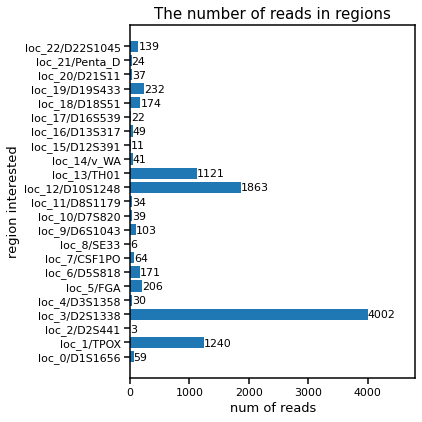

In [57]:
fig = plt.figure(figsize=(6, 6))
xbar = np.arange(len(region_dist))
plt.barh(xbar, region_dist['counts'])
plt.yticks(xbar, region_dist['regions'].values)
plt.xlim(0, max(region_dist['counts'])*1.2)
plt.ylabel('region interested')
plt.xlabel('num of reads')
plt.title('The number of reads in regions')
fig.tight_layout()


for i, v in enumerate(region_dist['counts']):
    plt.text(v, i-.25, str(v))